# Exploratory Data Analysis - Statistical Arbitrage Strategy

This notebook performs exploratory analysis of the data and features for the statistical arbitrage strategy.

In [2]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Import strategy modules
from src.data_acquisition import DataAcquisitionEngine
from src.feature_engineering import FeatureEngineer

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

%matplotlib inline

## 1. Data Acquisition

In [17]:
# Initialize data engine
data_engine = DataAcquisitionEngine(data_dir='../data', cache_enabled=True)

# Get sample universe
universe = data_engine.get_russell_3000_universe()[:50]  # Sample 50 stocks
print(f"Universe size: {len(universe)} stocks")
print(f"Sample tickers: {universe[:10]}")

2026-01-23 17:07:38.588 | INFO     | src.data_acquisition:__init__:40 - DataAcquisitionEngine initialized with cache at ../data
2026-01-23 17:07:38.589 | WARNING  | src.data_acquisition:get_russell_3000_universe:62 - Using sample universe. Implement actual Russell 3000 API for production.


Universe size: 27 stocks
Sample tickers: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA', 'BRK.B', 'JPM', 'JNJ']


In [18]:
# Download historical data
end_date = datetime.now()
start_date = end_date - timedelta(days=365 * 2)  # 2 years

df_raw = data_engine.get_training_data(
    tickers=universe,
    start_date=start_date,
    end_date=end_date,
    apply_filters=True
)


2026-01-23 17:07:40.524 | INFO     | src.data_acquisition:download_historical_data:96 - Loading cached data from ../data/cache_20240124_20260123.pkl
2026-01-23 17:07:40.541 | INFO     | src.data_acquisition:validate_data_quality:304 - Data validation complete. Report: {'total_rows': 13026, 'null_values': {}, 'outliers_removed': 0, 'tickers_removed': []}
2026-01-23 17:07:40.545 | INFO     | src.data_acquisition:filter_liquid_stocks:207 - Filtered to 26 liquid stocks from 26 total
2026-01-23 17:07:40.545 | INFO     | src.data_acquisition:exclude_high_risk_stocks:241 - Excluded 0 high-risk stocks
2026-01-23 17:07:40.547 | INFO     | src.data_acquisition:get_training_data:341 - Final dataset: 26 tickers, 13026 rows


## 2. Data Quality Analysis

In [19]:
print(f"\nData shape: {df_raw.shape}")
print(f"Date range: {df_raw.index.get_level_values(0).min()} to {df_raw.index.get_level_values(0).max()}")
df_raw.head()


Data shape: (13026, 5)
Date range: 2024-01-24 00:00:00 to 2026-01-22 00:00:00


Price                   Close        High         Low        Open    Volume
Date       ticker                                                          
2024-01-24 AAPL    192.680344  194.542760  192.521837  193.591735  53631300
           ABBV    153.305298  156.787383  153.155929  156.619354   5422200
           ADBE    606.479980  616.950012  597.460022  601.710022   2999000
           AMZN    156.869995  158.509995  156.479996  157.800003  48547300
           BAC      31.433546   31.776666   31.366829   31.481201  36403900

In [20]:
# Check for missing values
print("Missing values by column:")
print(df_raw.isnull().sum())

# Summary statistics
print("\nSummary statistics:")
df_raw.describe()

Missing values by column:
Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

Summary statistics:


Price,Close,High,Low,Open,Volume
count,13026.000000,13026.000000,13026.000000,13026.000000,1.302600e+04
mean,254.600507,257.233726,251.830772,254.575377,3.081545e+07
std,206.702386,208.670510,204.610797,206.719399,6.452793e+07
min,20.466091,20.854747,19.830968,20.011078,8.144000e+05
25%,102.389198,103.225692,101.261108,102.416662,5.781250e+06
50%,188.476616,190.490238,186.232574,188.370003,1.258745e+07
75%,353.924400,357.612988,349.810902,353.694502,2.926362e+07
max,1072.453613,1073.818003,1063.639858,1072.075171,1.142269e+09


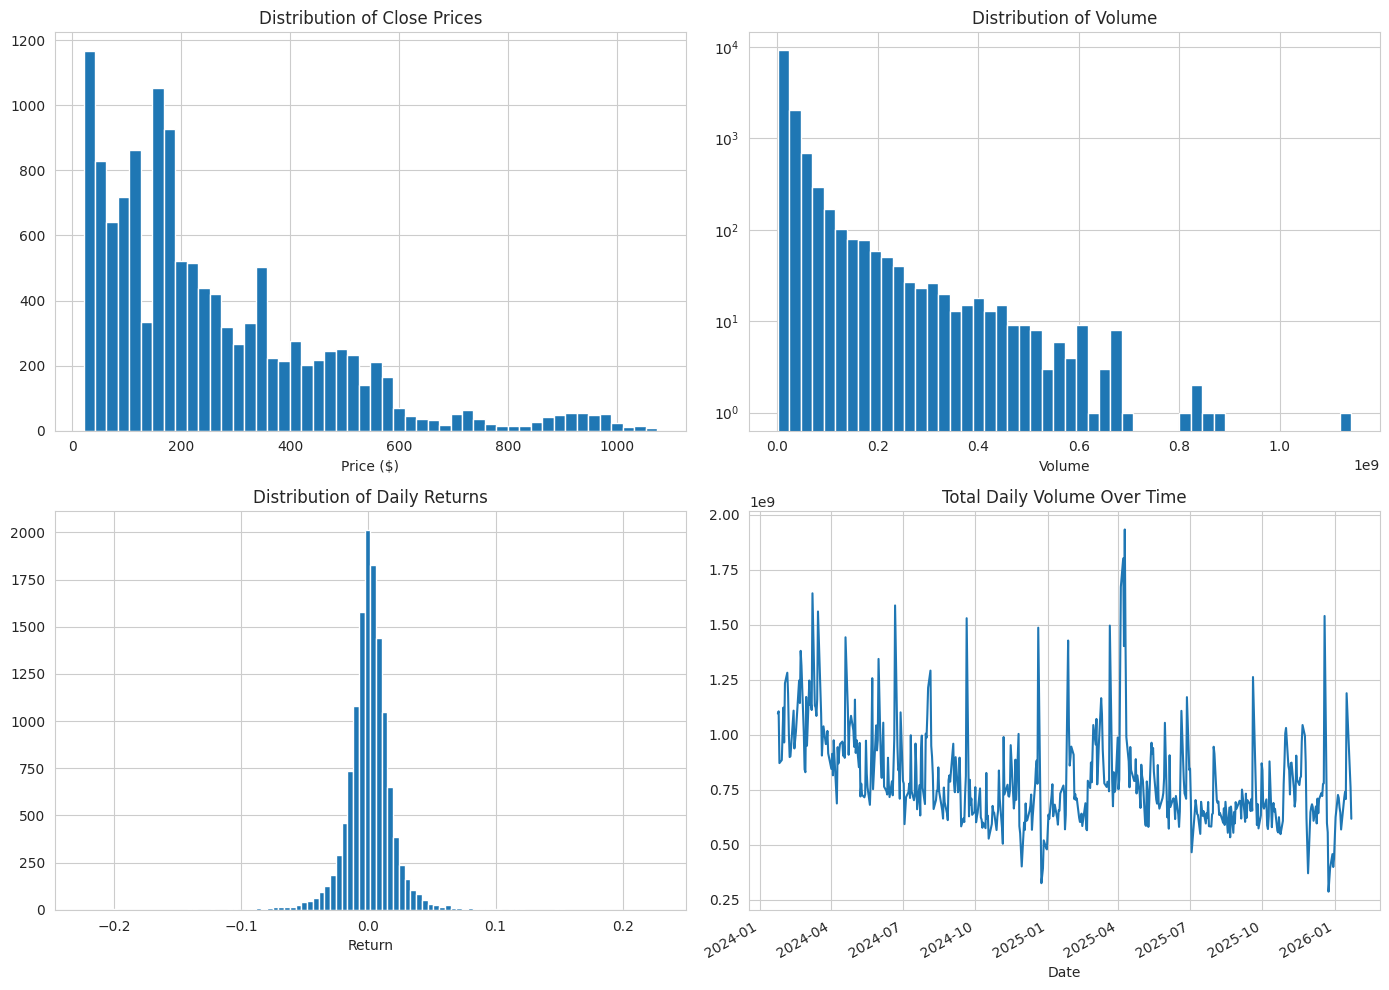

In [21]:
# Price distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Close prices
df_raw['Close'].hist(bins=50, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Close Prices')
axes[0, 0].set_xlabel('Price ($)')

# Volume
df_raw['Volume'].hist(bins=50, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Volume')
axes[0, 1].set_xlabel('Volume')
axes[0, 1].set_yscale('log')

# Daily returns
returns = df_raw.groupby('ticker')['Close'].pct_change()
returns.hist(bins=100, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Daily Returns')
axes[1, 0].set_xlabel('Return')

# Volume by date
daily_volume = df_raw.groupby(level=0)['Volume'].sum()
daily_volume.plot(ax=axes[1, 1])
axes[1, 1].set_title('Total Daily Volume Over Time')
axes[1, 1].set_xlabel('Date')

plt.tight_layout()
plt.show()

## 3. Feature Engineering

In [22]:
# Initialize feature engineer
feature_engineer = FeatureEngineer()

# Calculate all features
df_features = feature_engineer.calculate_all_features(df_raw, target_horizons=[3])

print(f"Features calculated: {df_features.shape}")
print(f"\nFeature columns: {df_features.columns.tolist()}")

2026-01-23 17:08:27.868 | INFO     | src.feature_engineering:__init__:45 - FeatureEngineer initialized with 6 momentum periods, 6 MA periods
2026-01-23 17:08:27.869 | INFO     | src.feature_engineering:calculate_all_features:228 - Starting feature calculation...
2026-01-23 17:08:27.965 | DEBUG    | src.feature_engineering:calculate_momentum_features:117 - Calculated 6 momentum features
2026-01-23 17:08:28.041 | DEBUG    | src.feature_engineering:calculate_mean_reversion_features:147 - Calculated 6 mean reversion features
2026-01-23 17:08:28.074 | DEBUG    | src.feature_engineering:calculate_volume_features:178 - Calculated volume features
2026-01-23 17:08:28.120 | DEBUG    | src.feature_engineering:calculate_volatility_features:210 - Calculated volatility features
2026-01-23 17:08:28.138 | INFO     | src.feature_engineering:calculate_all_features:246 - Feature calculation complete. Total features: 25


Features calculated: (13026, 25)

Feature columns: ['Close', 'High', 'Low', 'Open', 'Volume', 'log_return', 'momentum_5d', 'momentum_10d', 'momentum_20d', 'momentum_60d', 'momentum_126d', 'momentum_252d', 'distance_from_ma_10d', 'distance_from_ma_20d', 'distance_from_ma_50d', 'distance_from_ma_100d', 'distance_from_ma_200d', 'distance_from_ma_252d', 'relative_volume', 'volume_momentum_20d', 'volatility_20d', 'volatility_60d', 'hl_range', 'hl_range_ma20', 'forward_return_3d']


In [23]:
# Prepare ML dataset
X, y = feature_engineer.prepare_ml_dataset(df_features, target_col='forward_return_3d')

print(f"Feature matrix: {X.shape}")
print(f"Target vector: {y.shape}")
print(f"\nTarget statistics:")
print(y.describe())

2026-01-23 17:08:32.957 | INFO     | src.feature_engineering:prepare_ml_dataset:309 - Dropped NaN values. Remaining samples: 6396
2026-01-23 17:08:32.958 | INFO     | src.feature_engineering:prepare_ml_dataset:311 - ML dataset prepared: 6396 samples, 18 features, target: forward_return_3d


Feature matrix: (6396, 18)
Target vector: (6396,)

Target statistics:
count    6396.000000
mean        0.000485
std         0.034767
min        -0.322472
25%        -0.015798
50%         0.001819
75%         0.017747
max         0.198514
Name: forward_return_3d, dtype: float64


## 4. Feature Analysis

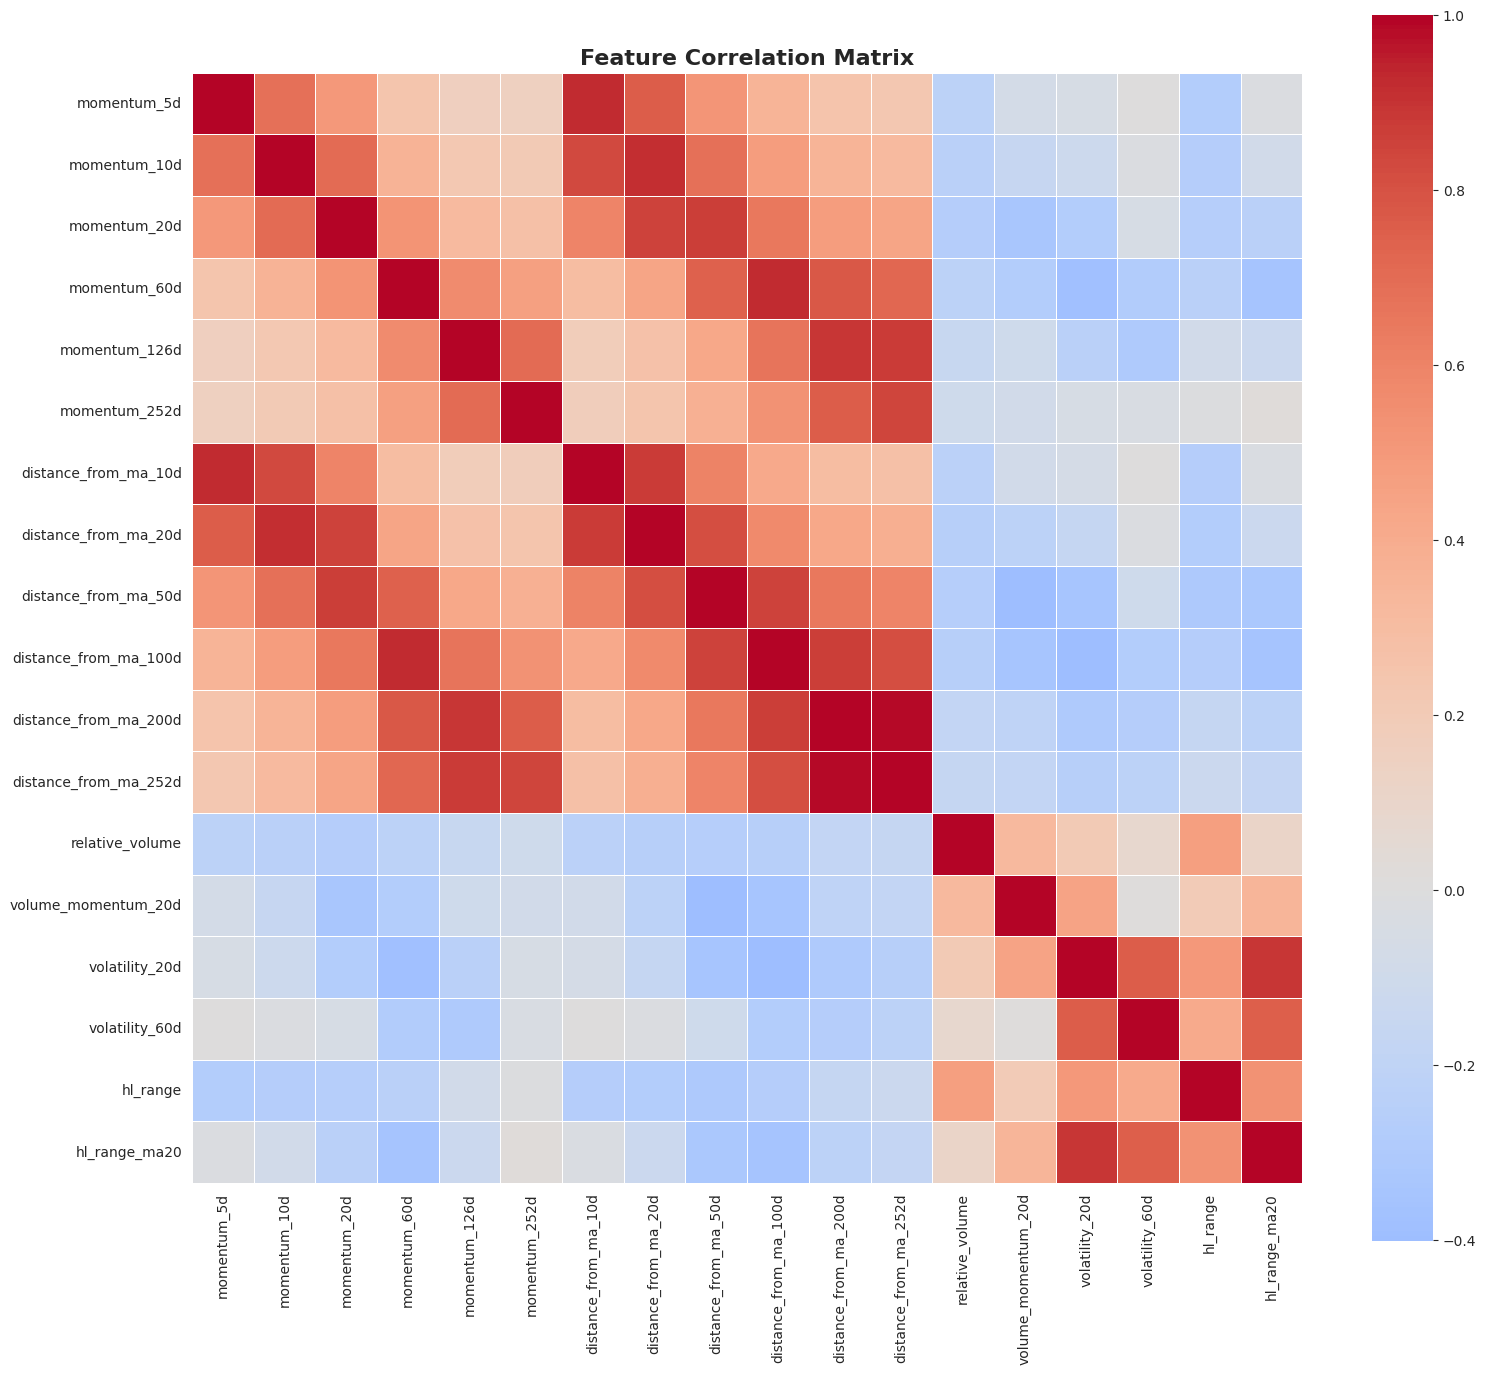

In [24]:
# Feature correlation matrix
plt.figure(figsize=(16, 14))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

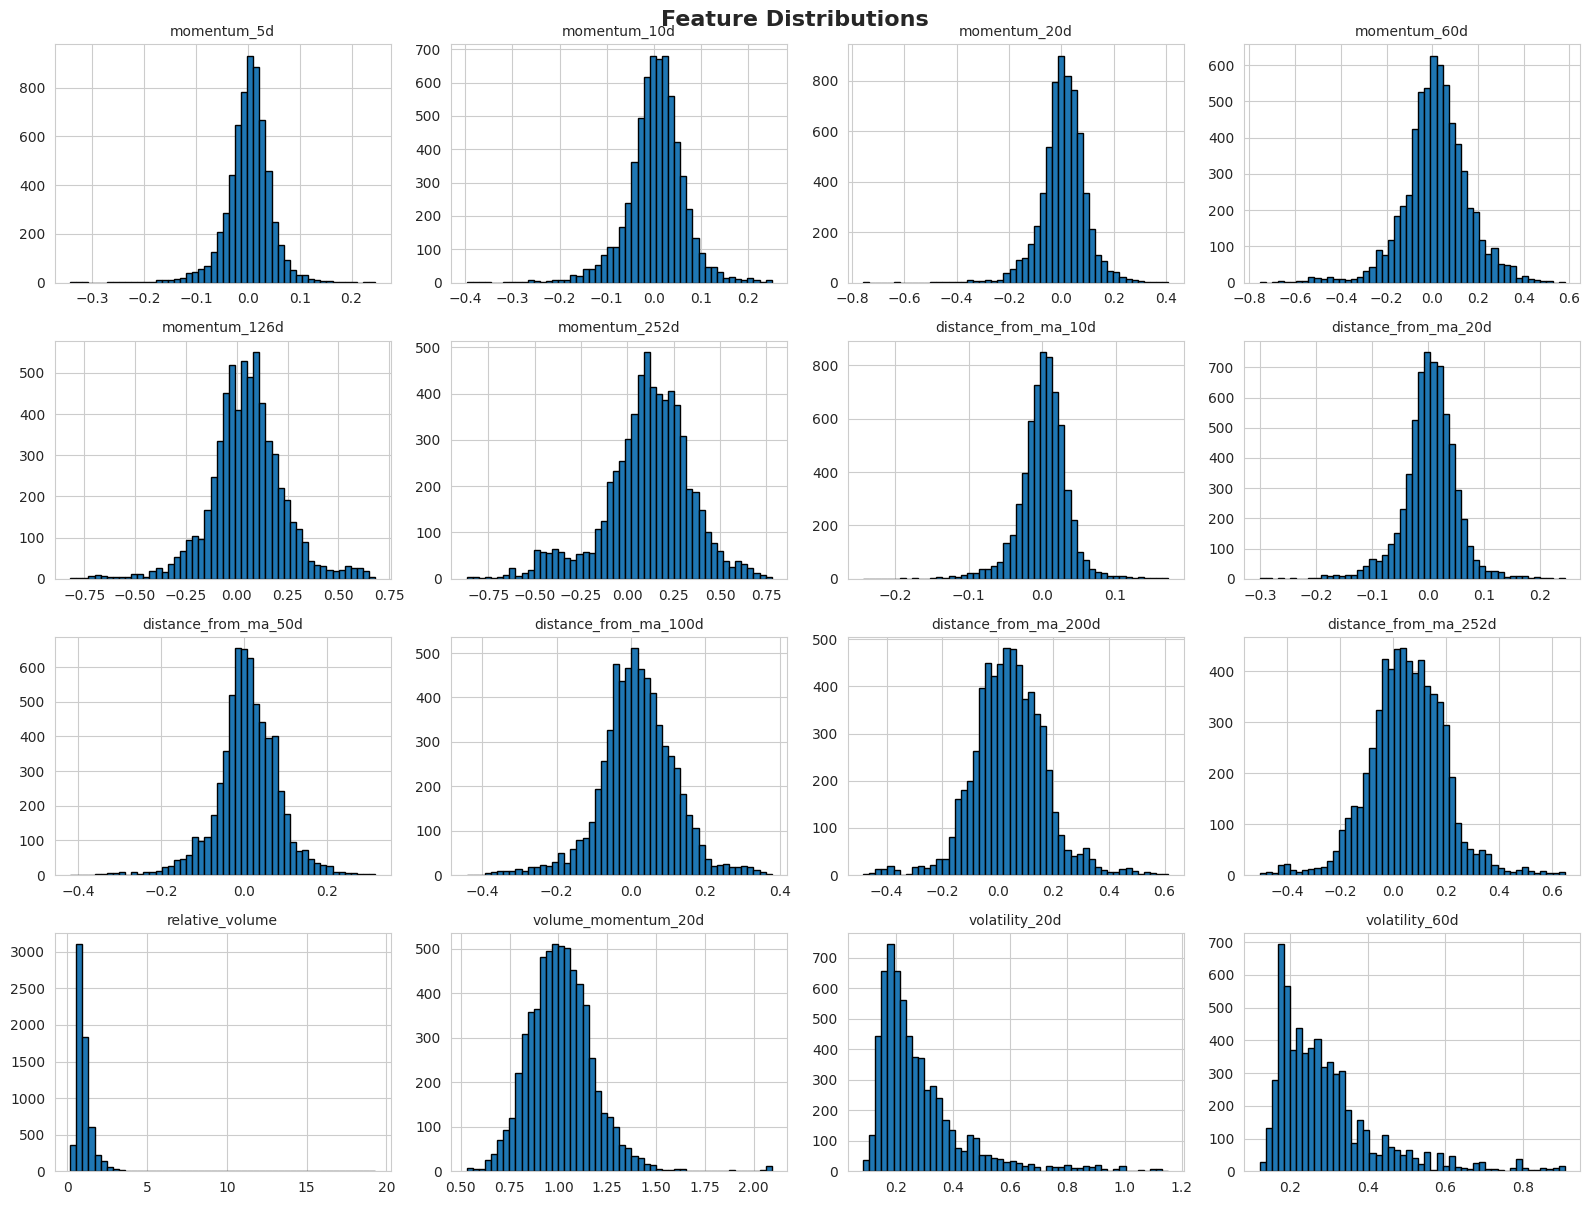

In [25]:
# Feature distributions
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()

for idx, col in enumerate(X.columns[:16]):  # First 16 features
    X[col].hist(bins=50, ax=axes[idx], edgecolor='black')
    axes[idx].set_title(col, fontsize=10)
    axes[idx].set_xlabel('')

plt.tight_layout()
plt.suptitle('Feature Distributions', y=1.00, fontsize=16, fontweight='bold')
plt.show()

## 5. Target Variable Analysis

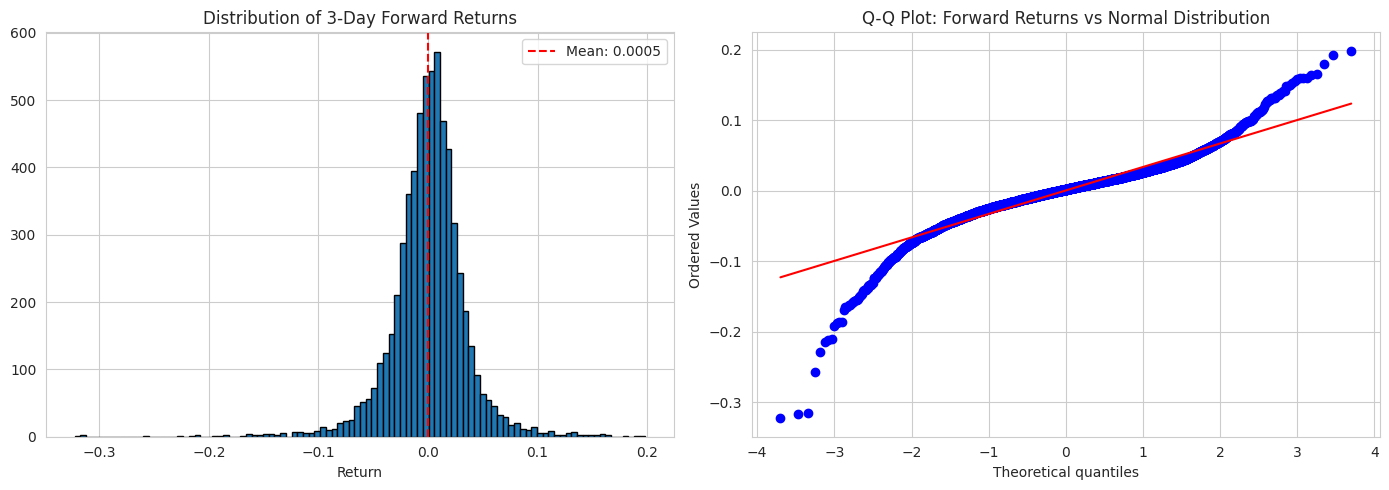


Target statistics:
Mean: 0.000485
Std: 0.034767
Skew: -0.7215
Kurtosis: 8.0857


In [26]:
# Target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
y.hist(bins=100, ax=axes[0], edgecolor='black')
axes[0].axvline(y.mean(), color='r', linestyle='--', label=f'Mean: {y.mean():.4f}')
axes[0].set_title('Distribution of 3-Day Forward Returns')
axes[0].set_xlabel('Return')
axes[0].legend()

# Q-Q plot
from scipy import stats
stats.probplot(y, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot: Forward Returns vs Normal Distribution')

plt.tight_layout()
plt.show()

print(f"\nTarget statistics:")
print(f"Mean: {y.mean():.6f}")
print(f"Std: {y.std():.6f}")
print(f"Skew: {y.skew():.4f}")
print(f"Kurtosis: {y.kurtosis():.4f}")

## 6. Feature-Target Relationships

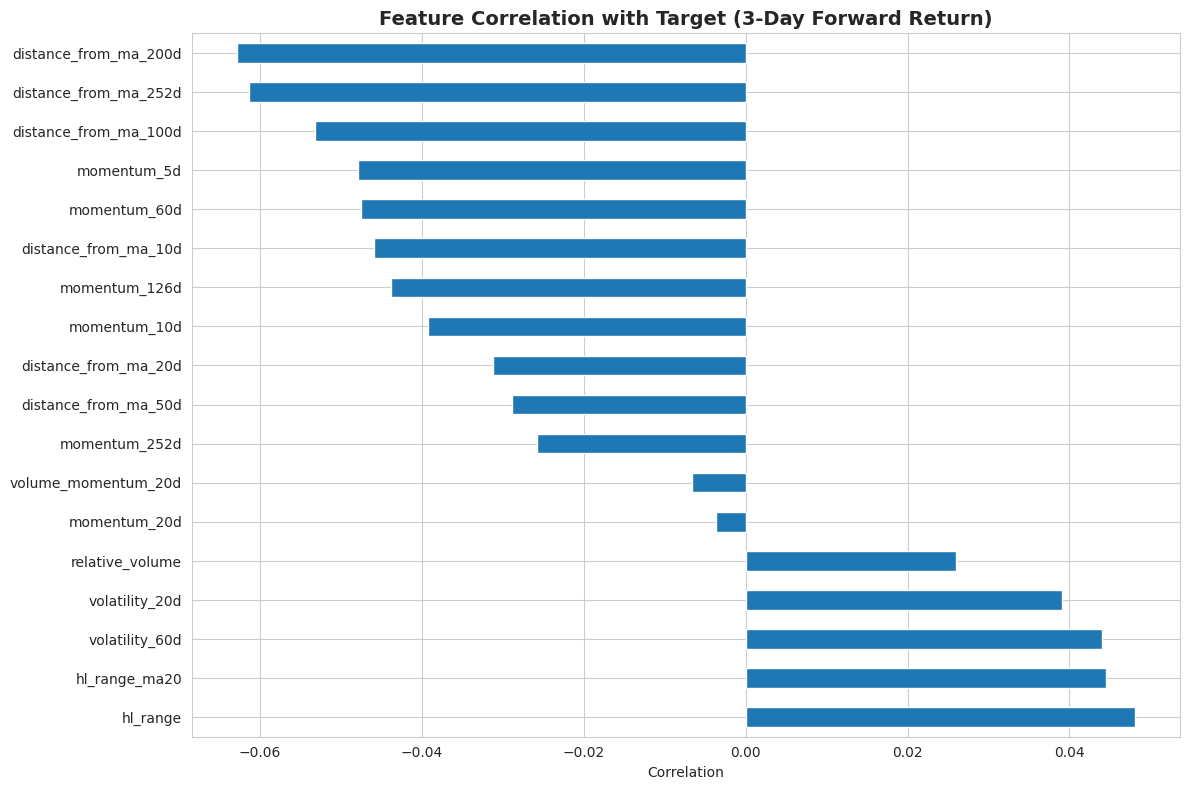


Top 10 features by correlation with target:
hl_range                0.048107
hl_range_ma20           0.044517
volatility_60d          0.044003
volatility_20d          0.039124
relative_volume         0.025926
momentum_20d           -0.003624
volume_momentum_20d    -0.006591
momentum_252d          -0.025789
distance_from_ma_50d   -0.028896
distance_from_ma_20d   -0.031165
dtype: float64


In [27]:
# Calculate correlation with target
feature_target_corr = X.corrwith(y).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
feature_target_corr.plot(kind='barh')
plt.title('Feature Correlation with Target (3-Day Forward Return)', fontsize=14, fontweight='bold')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()

print("\nTop 10 features by correlation with target:")
print(feature_target_corr.head(10))

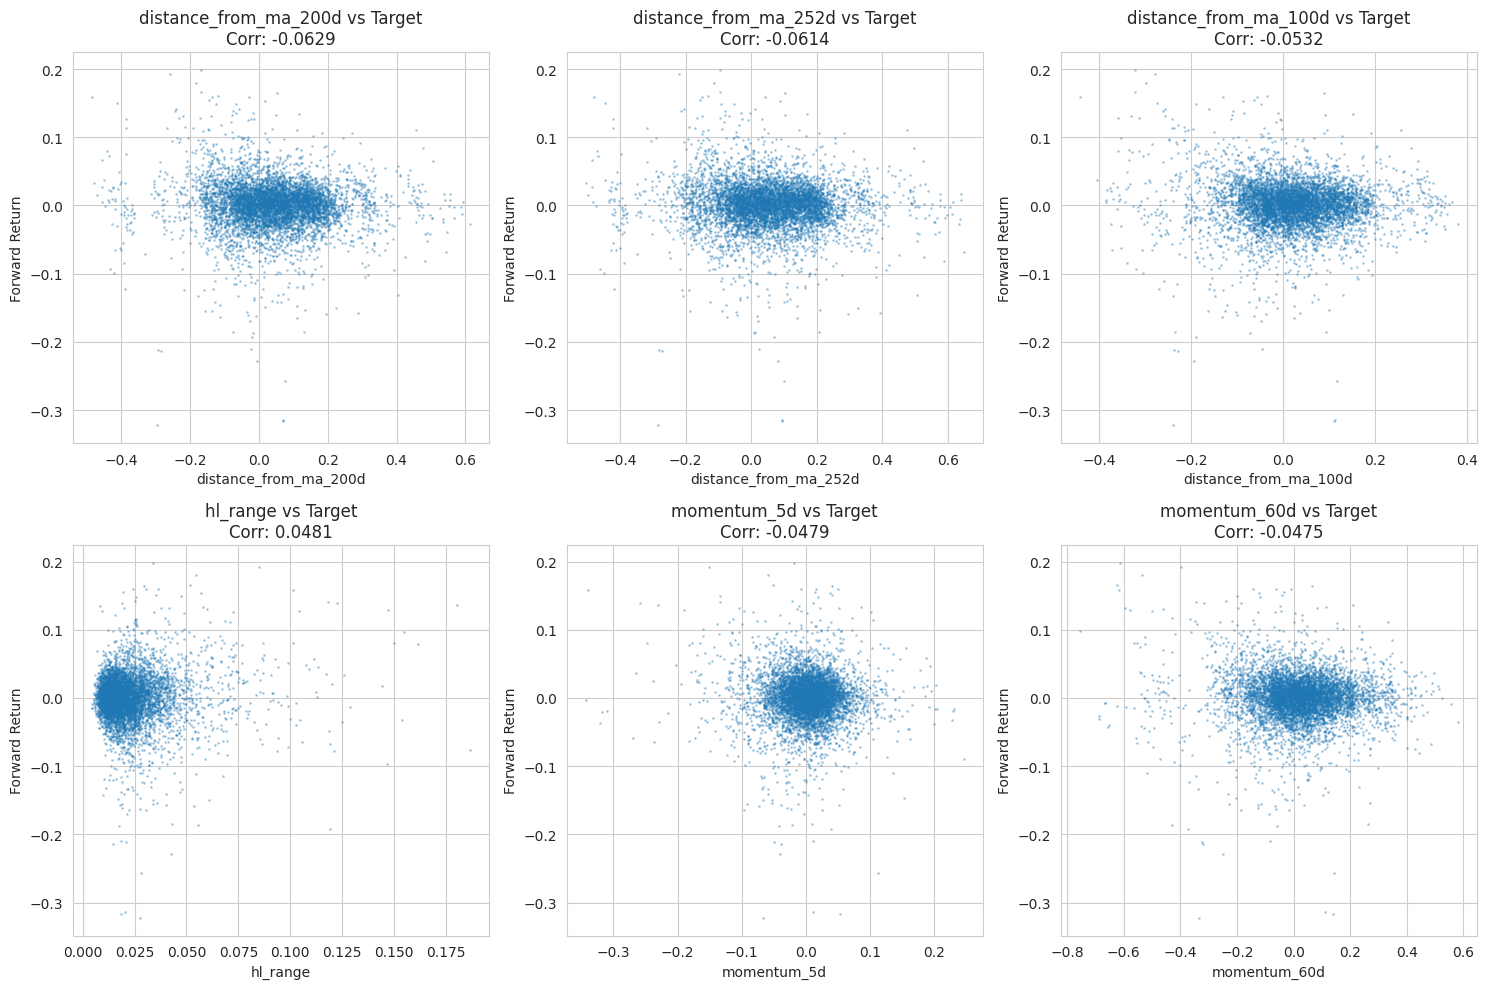

In [28]:
# Scatter plots for top features
top_features = feature_target_corr.abs().nlargest(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    axes[idx].scatter(X[feature], y, alpha=0.3, s=1)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Forward Return')
    axes[idx].set_title(f'{feature} vs Target\nCorr: {feature_target_corr[feature]:.4f}')

plt.tight_layout()
plt.show()